# Spectral Estimation with 3 different voltages

Before running this notebook, make sure `examples/notebooks/simulated_data_3voltages.ipynb` is executed to generate the simulated dataset.
This notebook provides an example to do spectral estimation with 3-voltage datasets.

In [1]:
# Basic Packages
import os
import matplotlib.pyplot as plt
import numpy as np
from xcal.estimate import Estimate
from xcal.defs import Material
from xcal._utils import *
from xcal.models import *
import spekpy as sp  # Import SpekPy

### A. Read datasets

In [2]:
# Read dataset.
data = np.load('../data/sim_3v1f1s_dataset.npy',allow_pickle=True)
num_src_v = len(data)

normalized_rads = [d['measurement'] for d in data]
forward_matrices = [d['forward_mat'] for d in data]
gt_sources = [d['source'] for d in data]
gt_filter = data[0]['filter']
gt_scint = data[0]['scintillator']

### B. X-ray System Model Configuration

A detailed explanation for spectral model configuration is available in `examples/notebooks/configure_spectral_models.ipynb`.

This section of the notebook configures the X-ray system model, specifying parameters that need to be estimated in given sets or given reange:

- Source anode angle (continuous): The anode angle refers to the angle the target surface of the anode sits at in relation to the vertical.
- Filter type (discrete) and thickness (continuous): Specifies the type of filter used in the system and its thickness.
- Scintillator (discrete) type and thickness (continuous): Determines the type of scintillator and its thickness.

The 3 ground truth spectral models are:

- source_1, filter_1, scintillator_1
- source_2, filter_1, scintillator_1
- source_3, filter_1, scintillator_1

In [3]:
# Set source's parameters.
voltage_list = [80.0, 130.0, 180.0]
simkV_list = np.linspace(30, 200, 18, endpoint=True).astype('int')
max_simkV = max(simkV_list)
reference_anode_angle = 11

# Detector pixel size in mm units.
dsize = 0.01  # mm

# Energy bins.
energies = np.linspace(1, max_simkV, max_simkV)

# Use Spekpy to generate a source spectra dictionary.
src_spec_list = []
for simkV in simkV_list:
    s = sp.Spek(kvp=simkV + 1, th=reference_anode_angle, dk=1, mas=1, char=True)  # Create the spectrum model
    k, phi_k = s.get_spectrum(edges=True)  # Get arrays of energy & fluence spectrum
    phi_k = phi_k * ((dsize / 10) ** 2)

    src_spec = np.zeros((max_simkV))
    src_spec[:simkV] = phi_k[::2]
    src_spec_list.append(src_spec)

voltage_list = [80.0, 130.0, 180.0]  # kV
sources = [Reflection_Source(voltage=(voltage, None, None), takeoff_angle=(25, 5, 45), single_takeoff_angle=True)
           for
           voltage in voltage_list]
for src_i, source in enumerate(sources):
    source.set_src_spec_list(src_spec_list, simkV_list, reference_anode_angle)

psb_fltr_mat = [Material(formula='Al', density=2.702), Material(formula='Cu', density=8.92)]
filter_1 = Filter(psb_fltr_mat, thickness=(5, 0, 10))

scint_params_list = [
    {'formula': 'CsI', 'density': 4.51},
    {'formula': 'Gd3Al2Ga3O12', 'density': 6.63},
    {'formula': 'Lu3Al5O12', 'density': 6.73},
    {'formula': 'CdWO4', 'density': 7.9},
    {'formula': 'Y3Al5O12', 'density': 4.56},
    {'formula': 'Bi4Ge3O12', 'density': 7.13},
    {'formula': 'Gd2O2S', 'density': 7.32}
]
psb_scint_mat = [Material(formula=scint_p['formula'], density=scint_p['density']) for scint_p in scint_params_list]
scintillator_1 = Scintillator(materials=psb_scint_mat, thickness=(0.25, 0.01, 0.5))

spec_models = [[source, filter_1, scintillator_1] for source in sources]

### C. Spectral Estimation

Xcal use exhaustive search to find the optimal discrete parameter combination and use LBFGS to find the optimal solution for continuous parameters.

The normalized_rads is $[y_1, y_2, y_3]$, forward_matrices is $[A_1, A_2, A_3]$, and spec_models is used to calculate $[x_1, x_2, x_3]$.

- $y_k$ should have dimension $N_{\text{views}}, N_{\text{rows}}, N_{\text{cols}}$.
- $A_k$ should have dimension $N_{\text{views}}, N_{\text{rows}}, N_{\text{cols}}, N_{\text{energies}}$.
- $x_k$ should have dimension $N_{\text{energies}}$.

In [4]:
learning_rate = 0.02
max_iterations = 5000
stop_threshold = 1e-5
optimizer_type = 'NNAT_LBFGS'

Estimator = Estimate(energies)
for nrad, forward_matrix, concatenate_models in zip(normalized_rads, forward_matrices, spec_models):
    Estimator.add_data(nrad, forward_matrix, concatenate_models, weight=None)

# Fit data
Estimator.fit(learning_rate=learning_rate,
              max_iterations=max_iterations,
              stop_threshold=stop_threshold,
              optimizer_type=optimizer_type,
              loss_type='transmission',
              logpath=None,
              num_processes=1)

Number of cases for different discrete parameters: 14


2024-04-02 02:59:24,598  - Start Estimation.
2024-04-02 02:59:24,733  - Initial cost: 1.702346e-03
2024-04-02 02:59:25,827  - Iteration: 5
2024-04-02 02:59:26,085  - Cost: 0.0005085425218567252
2024-04-02 02:59:26,086  - Filter_1_material: Material(formula='Al', density=2.702)
2024-04-02 02:59:26,086  - Filter_1_thickness: 4.02001428604126
2024-04-02 02:59:26,086  - Reflection_Source_1_voltage: 80.0
2024-04-02 02:59:26,086  - Reflection_Source_2_voltage: 130.0
2024-04-02 02:59:26,086  - Reflection_Source_3_voltage: 180.0
2024-04-02 02:59:26,086  - Reflection_Source_takeoff_angle: 25.212553024291992
2024-04-02 02:59:26,086  - Scintillator_1_material: Material(formula='CsI', density=4.51)
2024-04-02 02:59:26,086  - Scintillator_1_thickness: 0.24543984234333038
2024-04-02 02:59:26,086  - 
2024-04-02 02:59:27,081  - Iteration: 10
2024-04-02 02:59:27,335  - Cost: 0.0003573810390662402
2024-04-02 02:59:27,335  - Filter_1_material: Material(formula='Al', density=2.702)
2024-04-02 02:59:27,335

### D. Result Analysis

Retrieve the estimated parameter from Estimator.

Ground Truth Parameters:
{'Reflection_Source_4_voltage': tensor(80.), 'Reflection_Source_takeoff_angle': tensor(20.)}
{'Reflection_Source_5_voltage': tensor(130.), 'Reflection_Source_takeoff_angle': tensor(20.)}
{'Reflection_Source_6_voltage': tensor(180.), 'Reflection_Source_takeoff_angle': tensor(20.)}
{'Filter_2_material': Material(formula='Al', density=2.702), 'Filter_2_thickness': tensor(3.)}
{'Scintillator_2_material': Material(formula='CsI', density=4.51), 'Scintillator_2_thickness': tensor(0.3300)}
Estimated Parameters:
{'Reflection_Source_1_voltage': tensor(80.), 'Reflection_Source_takeoff_angle': tensor(19.5567, grad_fn=<ClampFunctionBackward>), 'Filter_1_material': Material(formula='Al', density=2.702), 'Filter_1_thickness': tensor(2.9787, grad_fn=<ClampFunctionBackward>), 'Scintillator_1_material': Material(formula='CsI', density=4.51), 'Scintillator_1_thickness': tensor(0.3284, grad_fn=<ClampFunctionBackward>), 'Reflection_Source_2_voltage': tensor(130.), 'Reflection_Sourc

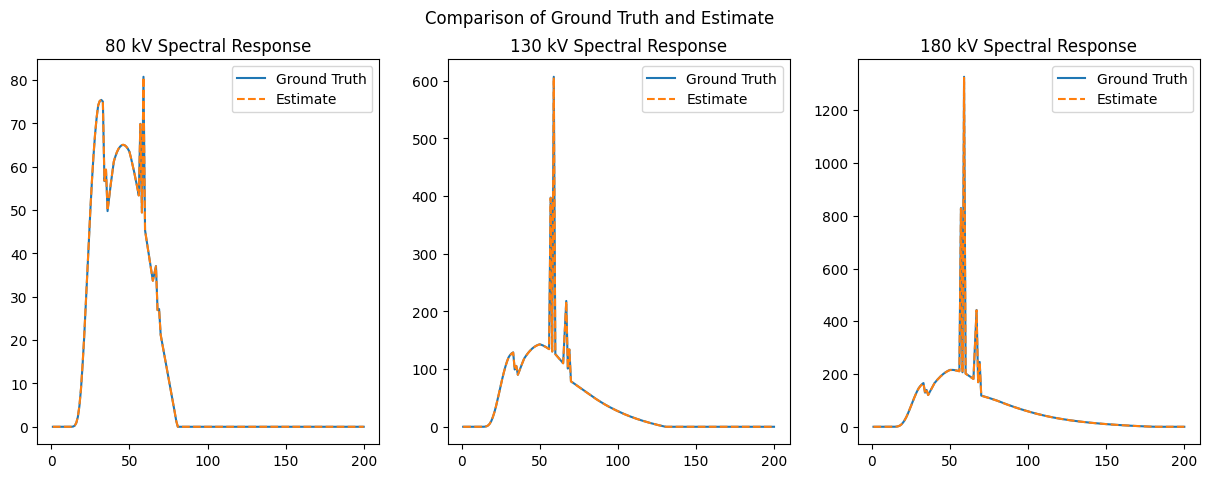

In [9]:
res_spec_models = Estimator.get_spec_models()
res_params = Estimator.get_params()

# Function to print a section of the table
def print_params(params):
    with (torch.no_grad()):
        for key, value in sorted(params.items()):
            if isinstance(value, tuple):
                print(f"{key}: {value[0].numpy()}")
            else:
                print(f"{key}: {value}")
        print()


# Print the table sections
print('Ground Truth Parameters:')
for gt_source in gt_sources:
    print(gt_source.get_params())
print(gt_filter.get_params())
print(gt_scint.get_params())

print('Estimated Parameters:')
# print_params(res_params)
print(res_params)

# Create a figure and axes objects for the subplot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot each subplot
for i in range(3):
    ax = axs[i]
    with torch.no_grad():
        ax.plot(energies, (gt_sources[i](energies) * gt_filter(energies) * gt_scint(energies)).numpy(),
                label='Ground Truth')
        ax.plot(energies, (
                    res_spec_models[i][0](energies) * res_spec_models[i][1](energies) * res_spec_models[i][2](
                energies)).numpy(), '--', label='Estimate')

    # Add legend
    ax.legend()

    # Add subplot title
    ax.set_title(f'{[80, 130, 180][i]} kV Spectral Response')

# Add common title
fig.suptitle('Comparison of Ground Truth and Estimate')

# Show the plot
plt.show()